# Abstractive Text Summarization Using Transformer with Self-Attention Mechanism (T2SAM)

Vinay Shasi - 801393998

Based on the research paper:</br>
Kumar, S., Solanki, A. An abstractive text summarization technique using transformer model with self-attention mechanism. Neural Comput & Applic 35, 18603–18622 (2023). https://doi.org/10.1007/s00521-023-08687-7

## Initial Imports

In [1]:
!pip install openpyxl  --quiet
!pip install tensorflow --quiet

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import re
import time

In [3]:
# Essential Constants
ENCODER_LENGTH = 140
DECODER_LENGTH = 40
BATCH_SIZE = 64
BUFFER_SIZE = BATCH_SIZE*8

## Checking and loading the dataset

Applying Start of Sentence() and End of Sentence() tokens. </br>
These sentences are then tokenized and padded to fix length.

In [4]:
news = pd.read_excel("/Users/vshasi/Documents/ITCS_5154 ML/Project/Trial/Inshorts Cleaned Data.xlsx", engine = 'openpyxl')
news.drop(['Source ', 'Time ', 'Publish Date'], axis=1, inplace=True)
news.head()

,Headline,Short
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a..."
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...


In [5]:
news.shape

(55104, 2)

In [6]:
short = news['Short']
headline = news['Headline']
short = short.apply(lambda x: '<SOS> ' + x + ' <EOS>')
headline = headline.apply(lambda x: '<SOS> ' + x + ' <EOS>')

In [7]:
# Replaces HTML entities in text with a space.
def preprocess(text):
    text = re.sub(r"&.[1-9]+;"," ",text)
    return text
short = short.apply(lambda x: preprocess(x))
headline = headline.apply(lambda x: preprocess(x))

In [8]:
# Tokenizes text data into sequences of integers, replacing out-of-vocabulary words with a special token.
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
out_of_vocabulary_token = '<unk>'
short_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token=out_of_vocabulary_token)
headline_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=out_of_vocabulary_token)
short_tokenizer.fit_on_texts(short)
headline_tokenizer.fit_on_texts(headline)
inputs = short_tokenizer.texts_to_sequences(short)
targets = headline_tokenizer.texts_to_sequences(headline)

In [9]:
# Calculate the sizes of the encoder and decoder vocabularies
ENCODER_VOCAB = len(short_tokenizer.word_index) + 1
DECODER_VOCAB = len(headline_tokenizer.word_index) + 1
print(ENCODER_VOCAB, DECODER_VOCAB)

76362 29661


In [10]:
# Pad input and target sequences to fixed lengths and cast to 64-bit integers
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=ENCODER_LENGTH, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences(targets, maxlen=DECODER_LENGTH, padding='post', truncating='post')
inputs = tf.cast(inputs, dtype=tf.int64)
targets = tf.cast(targets, dtype=tf.int64)

In [11]:
# Creating a TensorFlow dataset from the input and target data, shuffle, and batch
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Building the Transformer Model

The following code has code for the basic or vanilla transformer model.
This has been followed from the research paper.

In [12]:
# Calculate angle rates for positional encoding
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

# Generate positional encoding for a given sequence length and model dimension
def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

# Create a mask to ignore padding tokens in a sequence
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

# Create a mask to prevent attention to future tokens in a sequence
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

# Compute scaled dot-product attention between query, key, and value tensors
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights


In [13]:
# Multi-head attention mechanism
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
            
        return output, attention_weights
    
# Point-wise feed-forward neural network    
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

In [14]:
# Define a single layer of the encoder, consisting of multi-head attention and feed-forward network
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training=False, mask=None):
        # Multi-head attention
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        # Feed-forward network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [15]:
# Define a single layer of the decoder, consisting of two multi-head attention mechanisms and a feed-forward network
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training=False, look_ahead_mask=None, padding_mask=None):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

In [16]:
# Encoder architecture, containing embedding, positional encoding, and multiple encoder layers
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training=False, mask=None):  # Updated method signature
        seq_len = tf.shape(x)[1]

        # Add embedding and positional encoding
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        # Apply dropout
        x = self.dropout(x, training=training)

        # Pass through encoder layers
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training, mask=mask)  # Pass training as keyword

        return x
    
# Decoder architecture, containing embedding, positional encoding, and multiple decoder layers
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training=False, look_ahead_mask=None, padding_mask=None):  # Updated method signature
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](
                x, enc_output, training=training, look_ahead_mask=look_ahead_mask, padding_mask=padding_mask
            )

            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

        return x, attention_weights

In [17]:
# Transformer model architecture, consisting of encoder, decoder, and final linear layer
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training=False, enc_padding_mask=None, look_ahead_mask=None, dec_padding_mask=None):
        # Pass the training flag explicitly
        enc_output = self.encoder(inp, training=training, mask=enc_padding_mask)

        # Pass masks explicitly
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training=training, look_ahead_mask=look_ahead_mask, padding_mask=dec_padding_mask
        )

        # Final linear layer
        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [18]:
# Number of layers in the encoder and decoder
num_layers = 6 

# Dimensionality of the model
d_model = 128  

# Dimensionality of the feed-forward network
dff = 512

# Number of attention heads
num_heads = 8  

# Dropout rate for regularization
dropout_rate = 0.3

# Number of training epochs
EPOCHS = 5  

# Custom Learning Rate

In [19]:
# Define a custom learning rate schedule for the Transformer model
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    # Custom learning rate schedule with warmup and decay
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        # Computing the learning rate based on the current step
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [20]:
# Defining the optimizer for the Transformer model

# Custom learning rate schedule
learning_rate = CustomSchedule(d_model)

# Adam optimizer with the custom learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

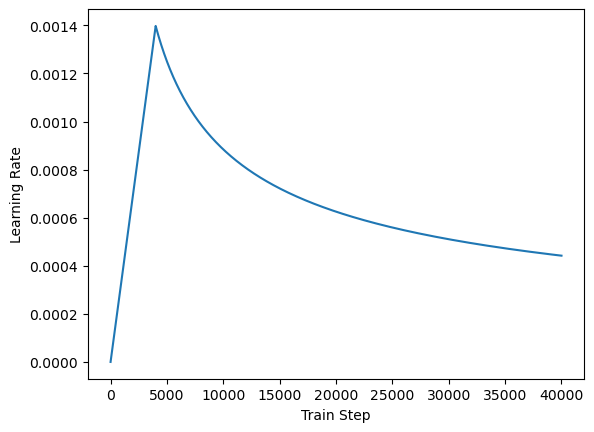

In [21]:
# Visualize the custom learning rate schedule
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Defining Custom Loss & Custom Accuracy Methods

In [22]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

# Custom loss function that masks out padding tokens
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

# Custom accuracy function that masks out padding tokens
def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [23]:
# Metrics for the transformer model
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [24]:
# Instantiating the Transformer model
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=ENCODER_VOCAB,
    target_vocab_size=DECODER_VOCAB,
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [25]:
# Masks for the transformer model
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    # combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, look_ahead_mask, dec_padding_mask

In [26]:
# Defining checkpoint manager and restoring the latest checkpoint
checkpoint_path = "checkpoints"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


# Training the Model

In [27]:
# Training step function for the Transformer model
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp, 
            training=True,  
            enc_padding_mask=enc_padding_mask, 
            dec_padding_mask=dec_padding_mask,
            look_ahead_mask=combined_mask
        )
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

In [28]:
# Train the Transformer model for the specified number of epochs
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_state()
  
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)
    
        if batch % 100 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
      
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
   
    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

/opt/anaconda3/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:731: UserWarning: Gradients do not exist for variables ['embeddings', 'embeddings', 'kernel'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch 1 Batch 0 Loss 9.6311 Accuracy 0.0029
Epoch 1 Batch 100 Loss 7.8828 Accuracy 0.0860
Epoch 1 Batch 200 Loss 7.7781 Accuracy 0.0905
Epoch 1 Batch 300 Loss 7.7268 Accuracy 0.0925
Epoch 1 Batch 400 Loss 7.7045 Accuracy 0.0953
Epoch 1 Batch 500 Loss 7.6796 Accuracy 0.0996
Epoch 1 Batch 600 Loss 7.6552 Accuracy 0.1036
Epoch 1 Batch 700 Loss 7.6301 Accuracy 0.1074
Epoch 1 Batch 800 Loss 7.6076 Accuracy 0.1103


2024-11-24 21:17:56.854751: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1 Loss 7.5923 Accuracy 0.1118
Time taken for 1 epoch: 1030.1078758239746 secs

Epoch 2 Batch 0 Loss 7.7025 Accuracy 0.1117
Epoch 2 Batch 100 Loss 7.3675 Accuracy 0.1115
Epoch 2 Batch 200 Loss 7.3463 Accuracy 0.1115
Epoch 2 Batch 300 Loss 7.3208 Accuracy 0.1117
Epoch 2 Batch 400 Loss 7.3203 Accuracy 0.1121
Epoch 2 Batch 500 Loss 7.3130 Accuracy 0.1131
Epoch 2 Batch 600 Loss 7.3040 Accuracy 0.1143
Epoch 2 Batch 700 Loss 7.2940 Accuracy 0.1156
Epoch 2 Batch 800 Loss 7.2850 Accuracy 0.1167


2024-11-24 21:35:47.177172: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2 Loss 7.2809 Accuracy 0.1173
Time taken for 1 epoch: 1070.3245429992676 secs

Epoch 3 Batch 0 Loss 7.5937 Accuracy 0.1173
Epoch 3 Batch 100 Loss 7.2786 Accuracy 0.1170
Epoch 3 Batch 200 Loss 7.2705 Accuracy 0.1168
Epoch 3 Batch 300 Loss 7.2542 Accuracy 0.1167
Epoch 3 Batch 400 Loss 7.2539 Accuracy 0.1168
Epoch 3 Batch 500 Loss 7.2465 Accuracy 0.1172
Epoch 3 Batch 600 Loss 7.2360 Accuracy 0.1179
Epoch 3 Batch 700 Loss 7.2273 Accuracy 0.1185
Epoch 3 Batch 800 Loss 7.2176 Accuracy 0.1192
Epoch 3 Loss 7.2140 Accuracy 0.1196
Time taken for 1 epoch: 1006.8257632255554 secs

Epoch 4 Batch 0 Loss 7.4939 Accuracy 0.1196
Epoch 4 Batch 100 Loss 7.2510 Accuracy 0.1193
Epoch 4 Batch 200 Loss 7.2435 Accuracy 0.1191
Epoch 4 Batch 300 Loss 7.2265 Accuracy 0.1190
Epoch 4 Batch 400 Loss 7.2263 Accuracy 0.1190
Epoch 4 Batch 500 Loss 7.2231 Accuracy 0.1193
Epoch 4 Batch 600 Loss 7.2124 Accuracy 0.1196
Epoch 4 Batch 700 Loss 7.2024 Accuracy 0.1201
Epoch 4 Batch 800 Loss 7.1919 Accuracy 0.1206


2024-11-24 22:09:47.141466: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4 Loss 7.1868 Accuracy 0.1209
Time taken for 1 epoch: 1033.1385488510132 secs

Epoch 5 Batch 0 Loss 7.5154 Accuracy 0.1209
Epoch 5 Batch 100 Loss 7.2326 Accuracy 0.1206
Epoch 5 Batch 200 Loss 7.2289 Accuracy 0.1205
Epoch 5 Batch 300 Loss 7.2122 Accuracy 0.1204
Epoch 5 Batch 400 Loss 7.2112 Accuracy 0.1204
Epoch 5 Batch 500 Loss 7.2054 Accuracy 0.1205
Epoch 5 Batch 600 Loss 7.1938 Accuracy 0.1208
Epoch 5 Batch 700 Loss 7.1833 Accuracy 0.1212
Epoch 5 Batch 800 Loss 7.1728 Accuracy 0.1216
Saving checkpoint for epoch 5 at checkpoints/ckpt-26
Epoch 5 Loss 7.1679 Accuracy 0.1218
Time taken for 1 epoch: 1023.6600031852722 secs



## Results Evaluation

In [35]:
# Evaluate the Transformer model
def evaluate(input_article):
    input_article = short_tokenizer.texts_to_sequences([input_article])
    input_article = tf.keras.preprocessing.sequence.pad_sequences(input_article, maxlen=ENCODER_LENGTH, 
                                                                   padding='post', truncating='post')

    encoder_input = tf.expand_dims(input_article[0], 0)

    decoder_input = [headline_tokenizer.word_index['<sos>']]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(DECODER_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(
            encoder_input, 
            output,
            training=False,
            enc_padding_mask=enc_padding_mask,
            look_ahead_mask=combined_mask,
            dec_padding_mask=dec_padding_mask
        )

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if predicted_id == headline_tokenizer.word_index['<eos>']:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [36]:
# Summarize an input article using the Transformer model
def summarize(input_article):
    summarized = evaluate(input_article=input_article)[0].numpy()
    summarized = np.expand_dims(summarized[1:], 0)  
    return headline_tokenizer.sequences_to_texts(summarized)[0]

## Predictions

Below we make predictions to see how the transformer model is performing. </br>
As this is a basic model, results can be improved with further tweaks and training params.

In [37]:
short[5]

'<SOS> A new trailer for the upcoming superhero film  Justice League  was released on Saturday. Based on the DC Comics superhero team, the film stars Ben Affleck as  Batman , Gal Gadot as  Wonder Woman , Ezra Miller as  The Flash  and Jason Momoa as  Aquaman . Directed by Zack Snyder, the film is scheduled to release on November 17, 2017. <EOS>'

In [38]:
print("Real Headline : ", headline[5][5:-5],"\n Predicted Summary : ", summarize(short[5]))

Real Headline :   New trailer of  Justice League  released  
 Predicted Summary :  


In [39]:
short[16]

'<SOS> As a part of an education initiative, the entire Wankhede Stadium will be reserved for underprivileged children for the IPL 2017 match between Mumbai Indians and Gujarat Lions, to be held on April 16. A statement by the Mumbai Indians read that they will not be selling any stand tickets for the team s third home game, against the Gujarat Lions. <EOS>'

In [40]:
print("Real Headline : ", headline[16][5:-5],"\nPredicted Summary : ", summarize(short[16]))

Real Headline :   Underprivileged kids to fill Wankhede during MI s IPL match  
Predicted Summary :  


In [44]:
summarize(short[3])

''